In [1]:
!pip install -q kaggle gradio tensorflow opencv-python scikit-learn seaborn matplotlib

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!chmod 600 /content/kaggle.json

In [5]:
!kaggle datasets list | head

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                             3491  2025-12-11 15:29:14.327000           2114        245  1.0              
kundanbedmutha/exam-score-prediction-dataset                      Exam Score Prediction Dataset                           325454  2025-11-28 07:29:01.047000           5863        281  1.0              
dansbecker/melbourne-housing-snapshot                             Melbourne Housing Snapshot                              461423  2018-06-05 12:52:24.087000         200095       1722  0.705882

In [6]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 1.48GB/s]


In [7]:
!unzip -q brain-mri-images-for-brain-tumor-detection.zip

In [8]:
!ls

brain-mri-images-for-brain-tumor-detection.zip	kaggle.json  sample_data
brain_tumor_dataset				no	     yes


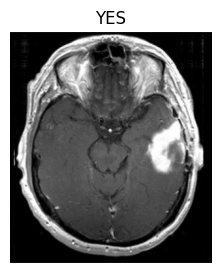

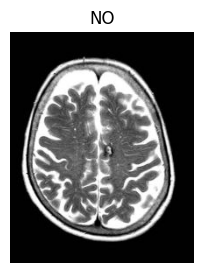

In [9]:
import matplotlib.pyplot as plt
import os
import cv2
import random

base_path = "/content/brain_tumor_dataset"

for label in ["yes", "no"]:
    folder = os.path.join(base_path, label)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(label.upper())
    plt.axis("off")
    plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

# Advanced augmentation for MRI images
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = train_gen.flow_from_directory(
    '/content/brain_tumor_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    '/content/brain_tumor_dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # freeze for initial training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)

model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4066 - loss: 0.7394 - val_accuracy: 0.3800 - val_loss: 0.7098
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4593 - loss: 0.7193 - val_accuracy: 0.3800 - val_loss: 0.6952
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4044 - loss: 0.7285 - val_accuracy: 0.6200 - val_loss: 0.6840
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5586 - loss: 0.6778 - val_accuracy: 0.6200 - val_loss: 0.6762
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5870 - loss: 0.6928 - val_accuracy: 0.6200 - val_loss: 0.6706
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6315 - loss: 0.6575 - val_accuracy: 0.6200 - val_loss: 0.6677
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6014 - loss: 0.6809 - val_accuracy: 0.6200 - val_loss: 0.6663
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5702 - loss: 0.6825 - val_accuracy: 0.6200 - val_loss: 0.6655
Epoch 9/

In [13]:
# Unfreeze top layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # freeze lower layers
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_ft = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5352 - loss: 0.7187 - val_accuracy: 0.6200 - val_loss: 0.6650
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4987 - loss: 0.7211 - val_accuracy: 0.6200 - val_loss: 0.6653
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5102 - loss: 0.7124 - val_accuracy: 0.6200 - val_loss: 0.6656
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4967 - loss: 0.6905 - val_accuracy: 0.6200 - val_loss: 0.6659
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5988 - loss: 0.6723 - val_accuracy: 0.6200 - val_loss: 0.6666


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Predictions
preds = model.predict(val_data).ravel()
labels = val_data.classes
binary_preds = (preds > 0.5).astype(int)

# Classification report
print(classification_report(labels, binary_preds))

# ROC AUC
print("ROC AUC:", roc_auc_score(labels, preds))


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.62      1.00      0.77        31

    accuracy                           0.62        50
   macro avg       0.31      0.50      0.38        50
weighted avg       0.38      0.62      0.47        50

ROC AUC: 0.41765704584040747


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


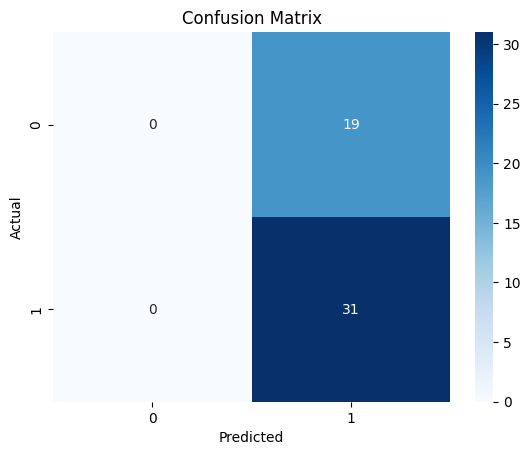

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, binary_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
import cv2
import tensorflow as tf

def grad_cam(img_array, model, layer_name='top_conv'):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, pred = grad_model(img_array)
        loss = pred[:, 0]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

def overlay_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)


In [30]:
import gradio as gr
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Grad-CAM helper functions (copied from Z1B6NXBLgWWf)
def grad_cam(img_array, model, layer_name='block7a_project_conv'): # Changed to a specific EfficientNetB0 layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, pred = grad_model(img_array)
        loss = pred[:, 0] # Assuming binary classification, target the output neuron for the positive class

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

def overlay_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Load your trained model


# --- Prediction function ---
def predict(image):
    if image is None:
        return "No image uploaded. Please upload an MRI scan.", None

    # Convert BGR -> RGB
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Safe resize
    try:
        img_resized = cv2.resize(img, (224, 224))
    except Exception as e:
        return f"Error resizing image: {str(e)}", None

    # Normalize
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # Model prediction
    pred_prob = model.predict(img_input)[0][0] # Get the single probability value
    prediction = "Tumor" if pred_prob > 0.5 else "No Tumor" # Convert probability to label

    # Generate Heatmap using Grad-CAM
    heatmap = grad_cam(img_input, model, layer_name='block7a_project_conv')
    # Overlay heatmap on the original resized image (before normalization for better visualization)
    heatmap_overlayed = overlay_heatmap(cv2.cvtColor(cv2.resize(image, (224, 224)), cv2.COLOR_BGR2RGB), heatmap)

    return prediction, heatmap_overlayed

# --- Gradio Interface ---
with gr.Blocks() as demo:
    gr.Markdown("## Brain Tumor Detector")
    with gr.Row():
        with gr.Column():
            img_input = gr.Image(type="numpy", label="Upload MRI Scan")
            predict_btn = gr.Button("Predict")
        with gr.Column():
            output_label = gr.Label(label="Prediction")
            output_img = gr.Image(label="Heatmap Overlay")

    predict_btn.click(
        fn=predict,
        inputs=img_input,
        outputs=[output_label, output_img]
    )

# Launch (Colab safe with share=True)
demo.launch(share=True)

ValueError: File not found: filepath=brain_tumor_detector.keras. Please ensure the file is an accessible `.keras` zip file.

In [25]:
model.save('brain_tumor_detector.h5')